# DensNet DL modeling on COVID-QU-Ex
In this notebook, we'll study an existing model for image recognition such as VGG16 and apply it on our dataset from Kaggle (https://www.kaggle.com/datasets/anasmohammedtahir/covidqu)

FIRST PART: Tunning
- Data will first be analyzed and prepare for modeling.
- The DensNet model from Keras will first be tuned (using KERAS tuner) to optimize its performance.
- The optimized model (known to be the "best" model) will then be trained of train set and validated on val set.
- The model will then be evaluated on the test set.

SECOND PART: Optimisation
- To optimize the model studied in first part, will re-train the model "un-freezing" the last convolutional layers (last 4 layers)
- The model will then be evaluated on the test set.

To conclude, we'll compare the "tuned model" and "optimized model"

In [1]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-04-29 09:31:58.487193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 09:31:58.487299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 09:31:58.737009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# Cell to import necessary library
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

import os

## 1- Data analysis
When first running this notebook, we'll need to transfer images files to the Kaggle working directory.

In [5]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base pat
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [4]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

100%|██████████| 2/2 [00:36<00:00, 18.38s/it]


In [6]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


# 2- Data preparation

In [7]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed



train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [8]:
# Preparation of the data set using image generator
batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="sparse",
                                                           target_size=(224, 224),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="sparse",
                                                         target_size=(224, 224),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="sparse",
                                                          target_size=(224, 224),
                                                          batch_size=batch_size, shuffle=False)
        # shuffle=False argument is very important for model evaluation 
        #(I spend many hours trying to figure it out)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


# 3- VGG26 Model tuning
Due to the significantly high computational duration, only 2 trial were performed to tuned only the 2 dropout rates.

In [9]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from  keras_tuner import RandomSearch
from  keras_tuner import HyperParameters
from tensorflow.keras.optimizers import Adam

# Define a function to build the model
def build_model(hp):
    # Load the pre-trained VGG16 model without the top layers
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the pre-trained layers so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),  
        Dense(128, activation='relu'),
        Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),  
        Dense(3, activation='softmax')  # Output layer with 3 classes
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),#Will be set to 0.0001 for fine tuning
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
# Instantiate the RandomSearch tuner to search for the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # optimize for validation accuracy
    max_trials=3,  # try 2 different hyperparameter combinations
    executions_per_trial=1,  
    directory='/kaggle/working/COVID-EX-Qu-dataset',  # directory to save logs and checkpoints
    project_name='densenet_tuning_2'  # name of the project
)
tuner.search_space_summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [11]:
tuner.search(train_generator,
             epochs=5,  
             validation_data=val_generator)

Trial 3 Complete [00h 10m 00s]
val_accuracy: 0.8798227906227112

Best val_accuracy So Far: 0.8798227906227112
Total elapsed time: 00h 31m 29s


In [12]:
# Retrieve and read tuned parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal dropout rate 1 is {best_hps.get('dropout_1')}.
The optimal dropout rate 2 is {best_hps.get('dropout_2')}.
""")


The optimal dropout rate 1 is 0.4.
The optimal dropout rate 2 is 0.30000000000000004.



In [14]:
# Build the model with the best hyperparameters
best_model_dnet = tuner.hypermodel.build(best_hps)

In [15]:
# tailes des échantillons
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_densenet_nonopt = best_model_dnet.fit(train_generator, 
                                epochs = 10,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=test_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/10
  1/678 ━━━━━━━━━━━━━━━━━━━━ 7:07:19 38s/step - accuracy: 0.4062 - loss: 1.4159

W0000 00:00:1714386243.565314     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/678 ━━━━━━━━━━━━━━━━━━━━ 16:19 1s/step - accuracy: 0.3703 - loss: 1.3885

W0000 00:00:1714386259.651373     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6794 - loss: 0.7351

W0000 00:00:1714386354.457247     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 168s 193ms/step - accuracy: 0.6795 - loss: 0.7349 - val_accuracy: 0.8713 - val_loss: 0.3368
Epoch 2/10
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:18 116ms/step - accuracy: 0.8125 - loss: 0.5709

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.8125 - loss: 0.5709 - val_accuracy: 0.8101 - val_loss: 0.5365
Epoch 3/10


W0000 00:00:1714386400.489734     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 101s 148ms/step - accuracy: 0.8082 - loss: 0.4714 - val_accuracy: 0.8347 - val_loss: 0.3965
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8438 - loss: 0.4181 - val_accuracy: 0.9630 - val_loss: 0.1961
Epoch 5/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 101s 148ms/step - accuracy: 0.8249 - loss: 0.4378 - val_accuracy: 0.8946 - val_loss: 0.2924
Epoch 6/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8125 - loss: 0.3994 - val_accuracy: 0.8116 - val_loss: 0.4833
Epoch 7/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 102s 149ms/step - accuracy: 0.8387 - loss: 0.4105 - val_accuracy: 0.8844 - val_loss: 0.2979
Epoch 8/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8125 - loss: 0.3496 - val_accuracy: 0.8391 - val_loss: 0.4268
Epoch 9/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 101s 148ms/step - accuracy: 0.8478 - loss: 0.3896 - val_accuracy: 0.8942 - val_loss: 0.2776
Epoch 10/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8750 - loss: 0.2607 - val_accura

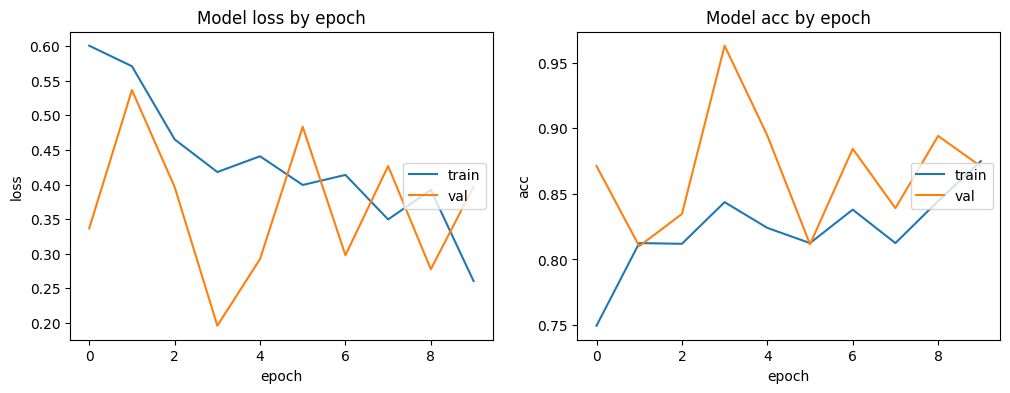

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_densenet_nonopt.history['loss'])
plt.plot(history_densenet_nonopt.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_densenet_nonopt.history['accuracy'])
plt.plot(history_densenet_nonopt.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [17]:
evaluation_nopt = best_model_dnet.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_nopt[0])
print("Test Accuracy:", evaluation_nopt[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - accuracy: 0.9185 - loss: 0.2234
Test Loss: 0.30066463351249695
Test Accuracy: 0.8899528384208679


In [18]:
best_model_dnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,897,163 (75.90 MB)

 Trainable params: 525,059 (2.00 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

 Optimizer params: 1,050,120 (4.01 MB)

# 4- DenseNet optimized


In [25]:
base_model_layers_count = len(best_model_dnet.layers[0].layers)
print("Number of layers in the base model: ", base_model_layers_count)

Number of layers in the base model:  707


In [26]:

for layer in best_model_dnet.layers[0].layers[100:]:
    layer.trainable = True

In [27]:
from tensorflow.keras.optimizers import Adam
best_model_dnet.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_best_model_dnet_opt = best_model_dnet.fit(train_generator, 
                                epochs = 10,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=test_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/10


W0000 00:00:1714388827.875178     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


642/678 ━━━━━━━━━━━━━━━━━━━━ 21s 609ms/step - accuracy: 0.8363 - loss: 0.4434

W0000 00:00:1714389218.261253     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.8383 - loss: 0.4374

W0000 00:00:1714389246.958203     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 699s 648ms/step - accuracy: 0.8384 - loss: 0.4373 - val_accuracy: 0.9418 - val_loss: 0.1616
Epoch 2/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9375 - loss: 0.4296 - val_accuracy: 0.8949 - val_loss: 0.3666
Epoch 3/10


W0000 00:00:1714389281.185186     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 261s 384ms/step - accuracy: 0.9324 - loss: 0.1888 - val_accuracy: 0.9532 - val_loss: 0.1314
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8125 - loss: 0.2676 - val_accuracy: 0.9413 - val_loss: 0.2337
Epoch 5/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 260s 383ms/step - accuracy: 0.9437 - loss: 0.1474 - val_accuracy: 0.9440 - val_loss: 0.1445
Epoch 6/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9375 - loss: 0.2065 - val_accuracy: 0.9543 - val_loss: 0.1593
Epoch 7/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 261s 383ms/step - accuracy: 0.9570 - loss: 0.1163 - val_accuracy: 0.9558 - val_loss: 0.1282
Epoch 8/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9375 - loss: 0.1453 - val_accuracy: 0.9486 - val_loss: 0.1710
Epoch 9/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 260s 383ms/step - accuracy: 0.9721 - loss: 0.0784 - val_accuracy: 0.9543 - val_loss: 0.1462
Epoch 10/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accura

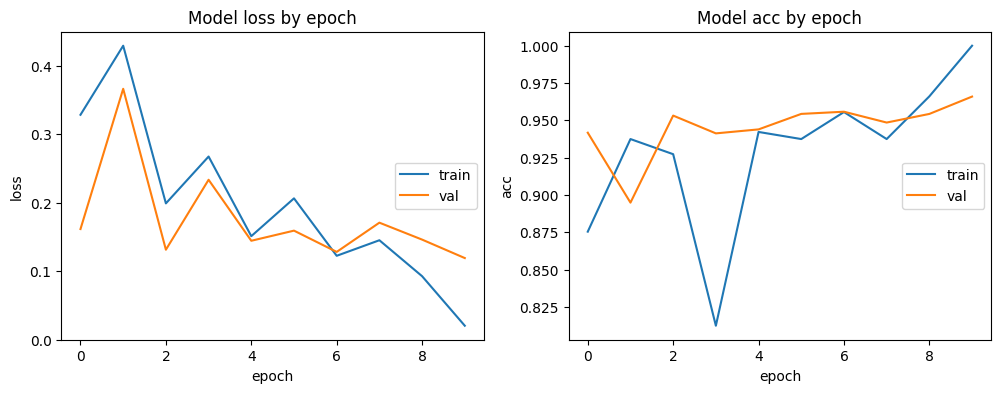

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_best_model_dnet_opt.history['loss'])
plt.plot(history_best_model_dnet_opt.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_best_model_dnet_opt.history['accuracy'])
plt.plot(history_best_model_dnet_opt.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

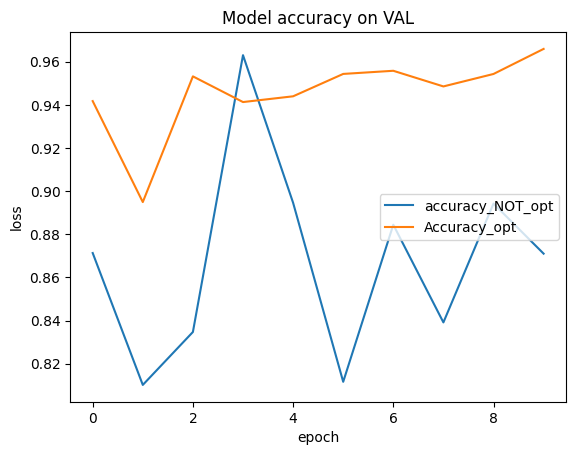

In [30]:
plt.plot(history_densenet_nonopt.history['val_accuracy'])
plt.plot(history_best_model_dnet_opt.history['val_accuracy'])
plt.title('Model accuracy on VAL')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy_NOT_opt', 'Accuracy_opt'], loc='right')

## 5- RESULTS

In [31]:
evaluation_opt = best_model_dnet.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_opt[0])
print("Test Accuracy:", evaluation_opt[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - accuracy: 0.9687 - loss: 0.1208
Test Loss: 0.13889940083026886
Test Accuracy: 0.9575721621513367


In [ ]:
# After model training
best_model_dnet.save('/kaggle/working/COVID-EX-Qu-dataset/OPT_densenet_baret.h5')  # saves the entire model to a HDF5 file

  2/213 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step

W0000 00:00:1714391035.597879     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step


W0000 00:00:1714391076.347792     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


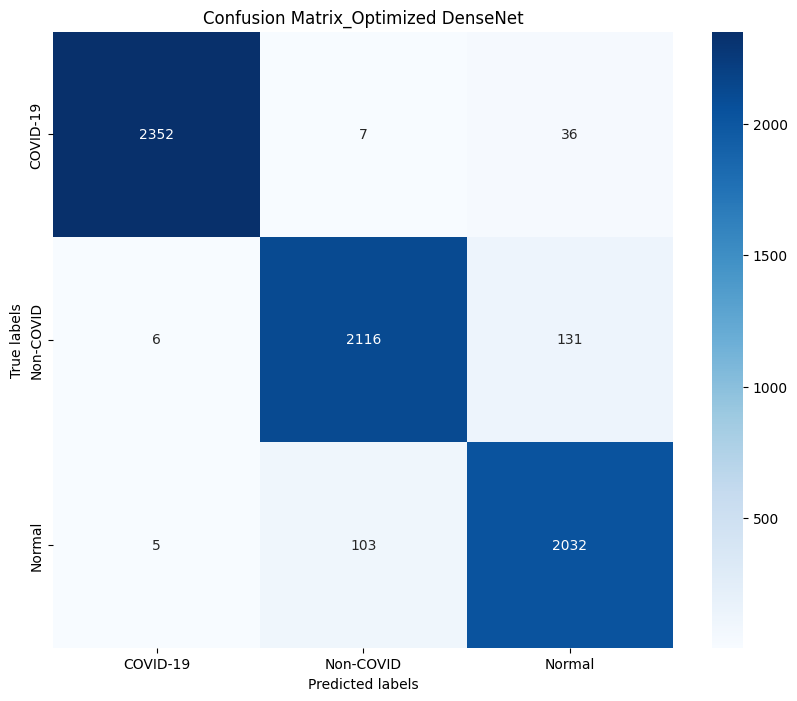

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
predictions = best_model_dnet.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized DenseNet')
plt.show()